### Extragalactic Astro HW #5: Galaxies, numerical exercise #3

Download the catalog of galaxies from the NASA Sloan Atlas between redshifts 0.01 < z <
0.05. Plot their absolute magnitude vs. color. Select several galaxies along the red and blue
sequences, and download and show their color images. For the same galaxies, download from
the SDSS database their spectra. Zoom in on the Hα region and the 4000 Ang region. Comment
on the major differences between the blue and red galaxies.

### Table of contents
#### 1. Extracting data from NSA and SDSS
#### 2. Plot the absolute magnitude vs color plot
#### 3. Show images of 3 blue objects
#### 4. Show spectra of 3 blue objects
#### 5. Show images of 3 red objects
#### 6. Show spectra of 3 red objects
#### 7. Comparison between blue and red galaxies

### 1. Extracting data from NSA and SDSS

Here we want to get objects of redshift 0.01<z<0.05 from NASA-Sloan Atlas (http://nsatlas.org/data ). The data file  nsa_v0_1_2.fits will give us the redshift, absolute magnitude, and color information we need to make an absolute magnitude vs color plot. We'll pick 3 blue and 3 red objects from this plot to study further.

To get the color images of the objects, we'll need to download their images from NSA. This is done by downloading http://sdss.physics.nyu.edu/mblanton/v0/detect/v0_1/[SUBDIR]/atlases/[PID]/[IAUNAME]-[PID]-atlas-[AID].fits.gz , specifying the fields in brackets for the desired object. I do this in the function plot_NSA_images. 

To get the spectra of the objects, we'll need to download their spectra from SDSS. This can be done using the SDSS download helper functions sdss_fits_url, sdss_fits_filename, and plot_NSA_spectra


In [1]:
#import stuff
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import urllib.request

In [2]:
"""
Tools to process NSA FITS files.

FNugriz photometric system used. See https://en.wikipedia.org/wiki/Photometric_system
"""

FILENAME  = 'data/nsa_v0_1_2.fits'

class NSA:
    """ NASA-Sloan-Atlas fits file 
    
    Parameters
    ----------
    FILENAME : string 
    file path to NSA fits file
    Notes
    -----
    refer to the data description:
    http://nsatlas.org/data

    """

    def __init__(self, FILENAME):
        self.hdulist = fits.open(FILENAME)
        self._initialize(self.hdulist)
        
        
    def _initialize(self, hdulist):
        data = hdulist[1].data
        self.absmag = data['ABSMAG']
        self.z = data['Z']
        self.ra = data['RA']
        self.dec = data['DEC']
        self.pid = data['PID']
        self.subdir = data['SUBDIR']
        self.iauname = data['IAUNAME']
        self.aid = data['AID']
        self.mjd = data['MJD']
        self.plate = data['PLATE']
        self.fiber = data['FIBERID']

    
    def close(self):
        self.hdulist.close()

In [3]:
"""
The following is adapted from AstroML AstroML/tools/sdss_fits.py, 
see https://github.com/astroML/astroML/blob/main/astroML/datasets/tools/sdss_fits.py

Tools to download and process SDSS fits files.
More information can be found at
http://www.sdss.org/dr7/products/spectra/index.html

Data Structure: the following is copied from http://www.sdss.org/dr7/dm/flatFiles/spSpec.html
The first row is the spectrum, the second row is the continuum subtracted spectrum, 
the third row is the noise in the spectrum (standard deviation, in the same units as the spectrum), 
the forth row is the mask array. The spectra are binned log-linear. Units are 10^(-17) erg/cm^2/s/Ang.

SDSS spectra are binned in constant Log(Λ ) and the wavelength can be obtained from the header 
parameters COEFF0 and COEFF1 (or alternatively CRVAL1 and CD1_1) as follows:

lambda = 10^(COEFF0 + COEFF1*i), where i denotes the (zero indexed) pixel number.

These HDUs list the measured properties of individual emission/absorption lines in the spectrum. 
There are two HDUs of this type. The first HDU of this type (HDU 1) lists all lines found automatically 
by the wavelet filter, with no apriori knowledge of the redshift. The second HDU of this type (HDU 2) 
lists all lines measured based on their expected positions from the highest-confidence emission line redshift. 
Under most circumstances, the line measurements in HDU 2 should be used.

"""


class SDSSfits:
    """ SDSS fits files
    
    Parameters
    ----------
    FILENAME : string 
    file path to SDSS fits file
    Notes
    -----
    refer to the data description:
    http://www.sdss.org/dr7/dm/flatFiles/spSpec.html
    """

    def __init__(self, FILENAME):
        self.hdulist = fits.open(FILENAME)
        self._initialize(self.hdulist)
        
        
    def _initialize(self, hdulist):
        data = hdulist[0].data

        self.name = hdulist[0].header['NAME']
        self.spec_cln = hdulist[0].header['SPEC_CLN']
        self.coeff0 = hdulist[0].header['COEFF0']
        self.coeff1 = hdulist[0].header['COEFF1']
        self.z = hdulist[0].header['Z']
        self.zerr = hdulist[0].header['Z_ERR']
        self.zconf = hdulist[0].header['Z_CONF']

        self.spectrum = data[0] # spectrum data
        self.spectrum_cont = data[1] 
        self.error = data[2] 
        self.mask = data[3] 
        
        self.lines = hdulist[2].data

    def get_line(self, wavelength):
        """
        get the desired line's wavelength. here, the input wavelength is the desired line's vacuum wavelength
        """
        index = np.where(np.abs(self.lines['restwave']-wavelength)<1)
        xloc = self.lines['wave'][index]
        return xloc

    def wavelength(self):
        """
        return the wavelength of the spectrum in angstroms
        """
        return 10 ** (self.coeff0 + self.coeff1 * np.arange(len(self.spectrum)))
    
    
    def close(self):
        self.hdulist.close()

In [4]:
"""
The following block is useful code from AstroML: see AstroML/datasets/tools/sdss_fits.py. It grabs the
desired FITS file from the SDSS database from user provided plate, mjd, and fiber number. It also provides
a line dictionary in vacuum wavelength.
"""
FITS_FILENAME = 'spSpec-%(mjd)05i-%(plate)04i-%(fiber)03i.fit'
SDSS_URL = ('http://das.sdss.org/spectro/1d_26/%(plate)04i/'
            '1d/spSpec-%(mjd)05i-%(plate)04i-%(fiber)03i.fit')

# lines, vacuum wavelength
LINES = dict(Ha=6564.61,
             Hb=4862.68,
             OI=6302.05,
             OIII=5008.24,
             NIIa=6549.86,
             NIIb=6585.27,
             SIIa=6718.29,
             SIIb=6732.67)


def sdss_fits_url(plate, mjd, fiber):
    """Return the URL of the spectrum FITS file"""
    return SDSS_URL % dict(plate=plate, mjd=mjd, fiber=fiber)


def sdss_fits_filename(plate, mjd, fiber):
    """Return the name of the spectrum FITS file"""
    return FITS_FILENAME % dict(plate=plate, mjd=mjd, fiber=fiber)

In [5]:
def plot_NSA_images(url, source_filepath, pic_id):
    """
    plot NSA child images given a desired object url. source_filepath is the filepath where the images will 
    be stored. plots the g-band and the r-band images. 
    """
    fig, ax = plt.subplots(1,2, figsize = (8,8))
    urllib.request.urlretrieve(url, source_filepath)
    #dest_filepath = source_filepath.replace('fits.gz', 'fits')
    datanew = fits.open(source_filepath)
    ax[0].imshow(datanew[3].data)   
    ax[1].imshow(datanew[4].data)
    ax[0].set_title(f'{pic_id} g band', fontsize = 14)
    ax[1].set_title(f'{pic_id} r band', fontsize = 14)
    

In [6]:
def plot_NSA_spectra(url, source_filepath, pic_id, WAVELENGTH, zoom = False):
    """
    plot SDSS spectra given a desired object url. source_filepath is the filepath where the spectra will 
    be stored. Set zoom = False to plot the whole spectrum, or zoom = True to zoom in on the desired
    line WAVELENGTH, specified in vacuum and Ang. This line will be marked with a vertical red dashed line 
    on the produced plots.
    """
    fig, ax = plt.subplots(1,1, figsize = (8,8))
    urllib.request.urlretrieve(url, source_filepath)
    #dest_filepath = source_filepath.replace('fits.gz', 'fits')
    #datanew = fits.open(source_filepath)
    SDSSobj = SDSSfits(source_filepath)
    line = SDSSobj.get_line(WAVELENGTH)
    wavelengths = SDSSobj.wavelength()
    spectrum = SDSSobj.spectrum_cont
    plt.plot(wavelengths,spectrum)
    plt.vlines(line, -20,100, color = 'r', linestyle = '--')
    plt.title(f'{pic_id} {WAVELENGTH} Ang', fontsize = 14)
    if zoom == True:
        plt.xlim(WAVELENGTH-500, WAVELENGTH+500)
    plt.xlabel('wavelength (Ang)', fontsize=14)
    plt.ylabel('10^(-17) erg/cm^2/s/Ang', fontsize=14)
    SDSSobj.close()

In [7]:
# extract the NSA data
NSAobj = NSA(FILENAME)
absmag = NSAobj.absmag
z = NSAobj.z
SUBDIR = NSAobj.subdir
PID = NSAobj.pid
IAUNAME = NSAobj.iauname
AID = NSAobj.aid
MJD = NSAobj.mjd
PLATE = NSAobj.plate
FIBER = NSAobj.fiber
NSAobj.close()

### 2. Plot the absolute magnitude vs color plot

Below we see the red sequence (marked in pink) and the blue cloud (marked in blue). Blueshifted objects are fainter and bluer, while redshifted objects are brighter and redder.

Text(0.5, 0, 'r [mag]')

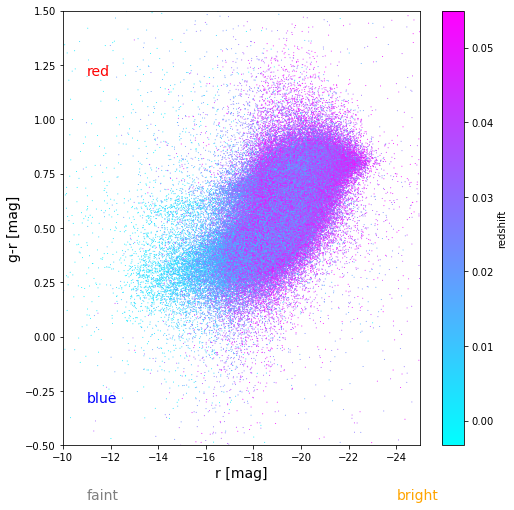

In [8]:
# plot the r vs u-r color-magnitude diagram
# adapted from https://www.astroml.org/examples/datasets/plot_nasa_atlas.html

g = absmag[:, 3]
r = absmag[:, 4]

fig, ax = plt.subplots(figsize = (8,8))
plt.scatter(r, g - r, s=1, lw=0, c=z, cmap=plt.cm.cool)
plt.colorbar(ticks=np.linspace(0, 0.05, 6)).set_label('redshift')

plt.ylim(-0.5, 1.5)
plt.xlim(-10, -25)

plt.text(-11, -.3, 'blue', color = 'blue', fontsize = 14)
plt.text(-11, 1.2, 'red', color = 'red', fontsize = 14)

plt.text(-11, -.75, 'faint', color = 'grey', fontsize = 14)
plt.text(-24,-0.75, 'bright', color = 'orange', fontsize = 14)

plt.ylabel('g-r [mag]', fontsize=14)
plt.xlabel('r [mag]', fontsize=14)

### 3. Show images of 3 blue objects

Below I choose 3 blue objects from the blue cloud and show their images in the g band and the r band. 

In [9]:
# Choose a 3 blue sequence objects to show images/spectra of

#blue:
wh_blue = np.where(r>-15)
#choose 0, 1, 2 as blues
blue_0 = wh_blue[0][0]
blue_1 = wh_blue[0][1]
blue_2 = wh_blue[0][2]
#get the coords
blue_0_subdir = SUBDIR[blue_0]
blue_0_pid = PID[blue_0]
blue_0_iauname = IAUNAME[blue_0]
blue_0_aid = AID[blue_0]
blue_0_plate = PLATE[blue_0]
blue_0_fiber = FIBER[blue_0]
blue_0_mjd = MJD[blue_0]
#get the coords
blue_1_subdir = SUBDIR[blue_1]
blue_1_pid = PID[blue_1]
blue_1_iauname = IAUNAME[blue_1]
blue_1_aid = AID[blue_1]
blue_1_plate = PLATE[blue_1]
blue_1_fiber = FIBER[blue_1]
blue_1_mjd = MJD[blue_1]
#get the coords
blue_2_subdir = SUBDIR[blue_2]
blue_2_pid = PID[blue_2]
blue_2_iauname = IAUNAME[blue_2]
blue_2_aid = AID[blue_2]
blue_2_plate = PLATE[blue_2]
blue_2_fiber = FIBER[blue_2]
blue_2_mjd = MJD[blue_2]

#pack into lists
blue_subdirs = [blue_0_subdir , blue_1_subdir, blue_2_subdir]
blue_pids = [blue_0_pid , blue_1_pid, blue_2_pid]
blue_iaunames = [blue_0_iauname , blue_1_iauname, blue_2_iauname]
blue_aids = [blue_0_aid , blue_1_aid, blue_2_aid]
blue_plates = [blue_0_plate , blue_1_plate, blue_2_plate]
blue_mjds = [blue_0_mjd , blue_1_mjd, blue_2_mjd]
blue_fibers = [blue_0_fiber , blue_1_fiber, blue_2_fiber]

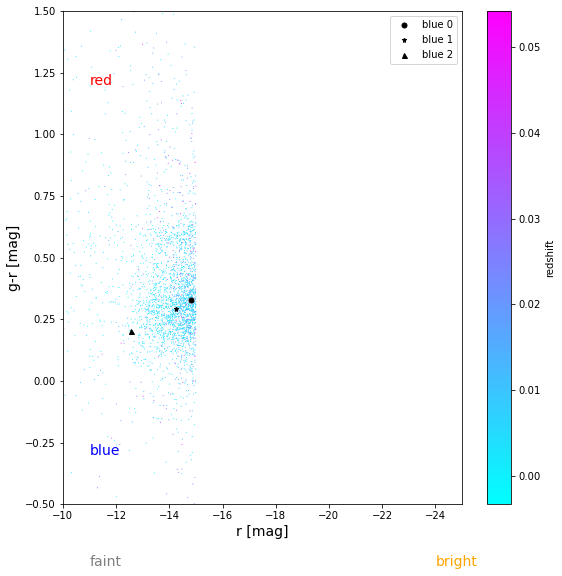

In [10]:
# plot which blue objects we're taking a closer look at

fig, ax = plt.subplots(figsize = (8,8))
plt.scatter(r[wh_blue], (g - r)[wh_blue], s=1, lw=0, c=z[wh_blue], cmap=plt.cm.cool, zorder=0)
plt.colorbar(ticks=np.linspace(0, 0.05, 6)).set_label('redshift')
plt.plot(r[blue_0], (g - r)[blue_0], marker = 'o', color = 'black', \
         linestyle = 'None', markersize = 5, label = 'blue 0', zorder=1)
plt.plot(r[blue_1], (g - r)[blue_1], marker = '*', color = 'black',  \
         linestyle = 'None', markersize = 5, label = 'blue 1', zorder=1)
plt.plot(r[blue_2], (g - r)[blue_2], marker = '^', color = 'black',  \
         linestyle = 'None', markersize = 5, label = 'blue 2', zorder=1)

plt.ylim(-0.5, 1.5)
plt.xlim(-10, -25)

plt.text(-11, -.3, 'blue', color = 'blue', fontsize = 14)
plt.text(-11, 1.2, 'red', color = 'red', fontsize = 14)

plt.text(-11, -.75, 'faint', color = 'grey', fontsize = 14)
plt.text(-24,-0.75, 'bright', color = 'orange', fontsize = 14)

plt.ylabel('g-r [mag]', fontsize=14)
plt.xlabel('r [mag]', fontsize=14)
plt.legend()
plt.tight_layout()

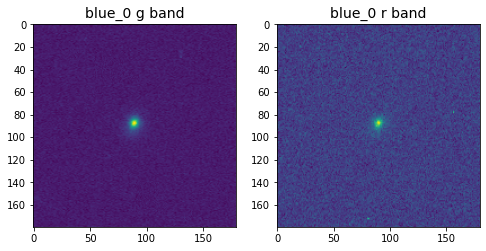

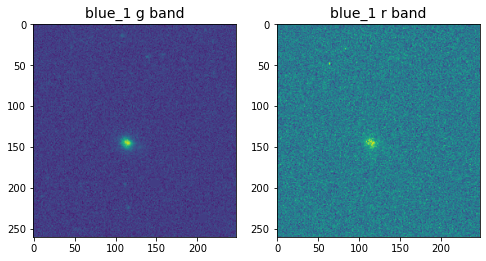

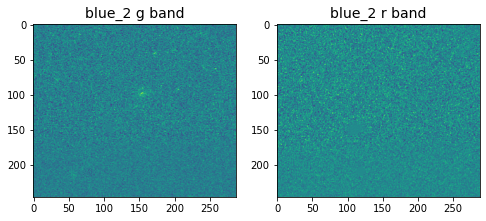

In [11]:
# plot the g and r band images of the 3 blue objects we've chosen to study
for i in range(len(blue_pids)):
    pid = blue_pids[i]
    iauname = blue_iaunames[i]
    pid = blue_pids[i]
    aid = blue_aids[i]
    subdir = blue_subdirs[i]
    #for child image
    url = f'http://sdss.physics.nyu.edu/mblanton/v0/detect/v0_1/{subdir}/atlases/{pid}/{iauname}-{pid}-atlas-{aid}.fits.gz'
    source_filepath = f'data/{iauname}-{pid}-atlas-{aid}.fits.gz'
    pic_id = f'blue_{i}'
    #for parent image
    #url = f'http://sdss.physics.nyu.edu/mblanton/v0/detect/v0_1/{subdir}/atlases/{pid}/{iauname}-parent-{pid}.fits.gz'
    #source_filepath = 'data/{iauname}-parent-{pid}.fits.gz'
    plot_NSA_images(url, source_filepath, pic_id)

### 4. Show spectra of 3 blue objects

In the below, for my 3 chosen blue objects, I show 1) their entire SDSS spectrum with the H-alpha line marked in red, 2) their SDSS spectrum zoomed in on the H-alpha line with the H-alpha line marked in red, and 3) their SDSS spectrum zoomed in on the H-beta line (~4000 Ang in vacuum) with the H-beta line marked in red.

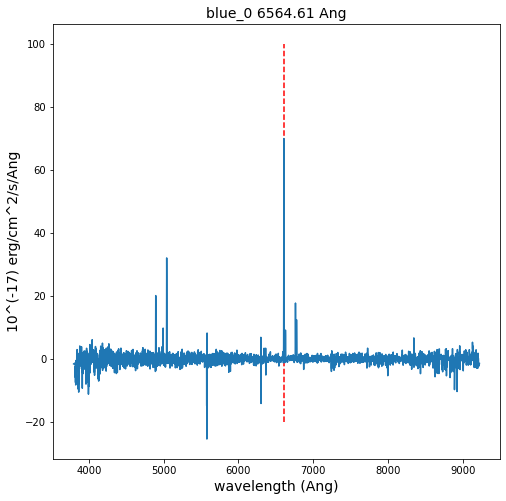

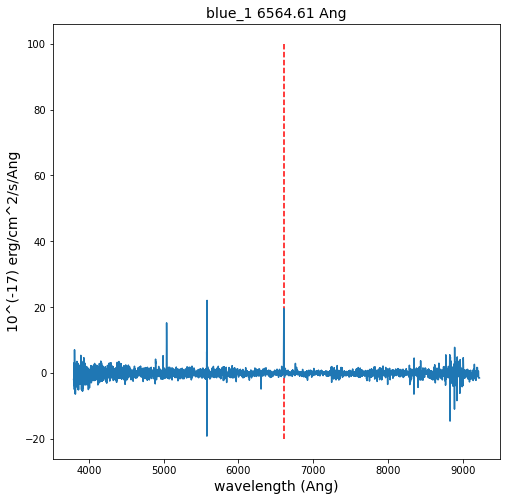

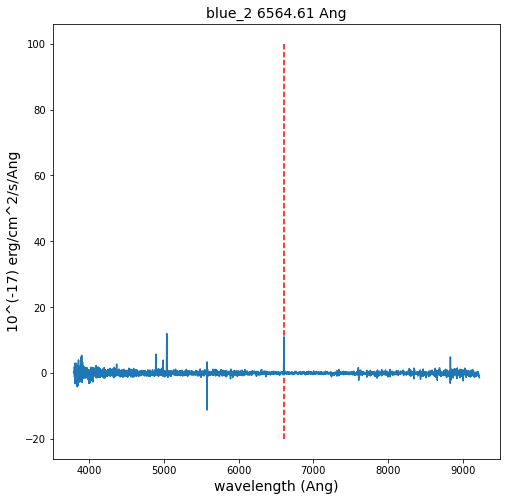

In [12]:
#get spectra from SDSS of the 3 blue objects we've chosen to study
# here we're plotting the full spectrum and marking the H-alpha line in red 
WAVELENGTH = LINES['Ha']
for i in range(len(blue_plates)):
    mjd = blue_mjds[i]
    plate = blue_plates[i]
    fiber = blue_fibers[i]
    source_filename = sdss_fits_filename(plate, mjd, fiber)
    url = sdss_fits_url(plate, mjd, fiber)
    pic_id = f'blue_{i}'
    source_filepath = f'data/{source_filename}'
    plot_NSA_spectra(url, source_filepath, pic_id, WAVELENGTH, zoom = False)

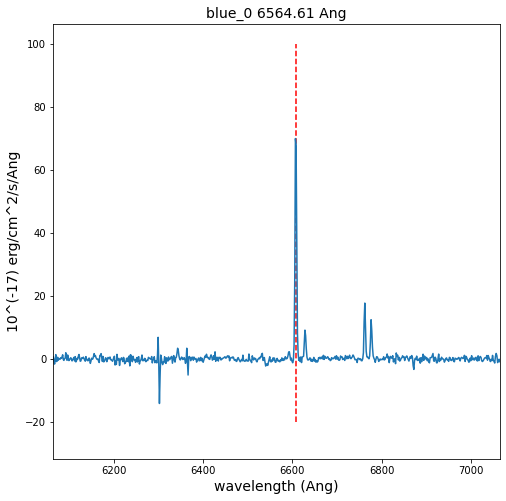

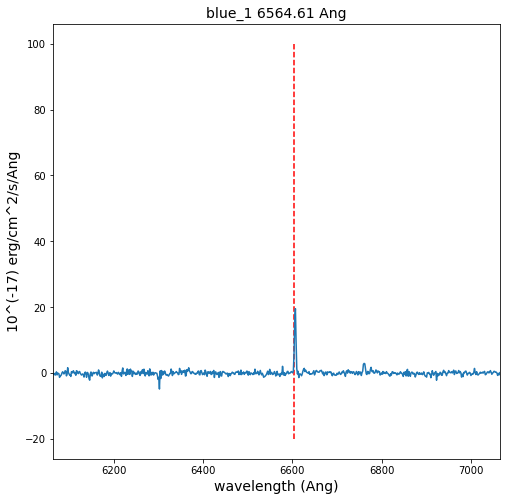

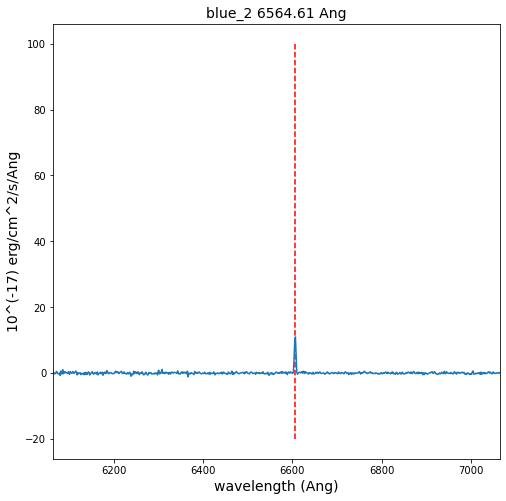

In [13]:
#get spectra from SDSS of the 3 blue objects we've chosen to study
# here we're zooming in on the H-alpha line and marking the H-alpha line in red 
WAVELENGTH = LINES['Ha']
for i in range(len(blue_plates)):
    mjd = blue_mjds[i]
    plate = blue_plates[i]
    fiber = blue_fibers[i]
    source_filename = sdss_fits_filename(plate, mjd, fiber)
    url = sdss_fits_url(plate, mjd, fiber)
    pic_id = f'blue_{i}'
    source_filepath = f'data/{source_filename}'
    plot_NSA_spectra(url, source_filepath, pic_id, WAVELENGTH, zoom = True)

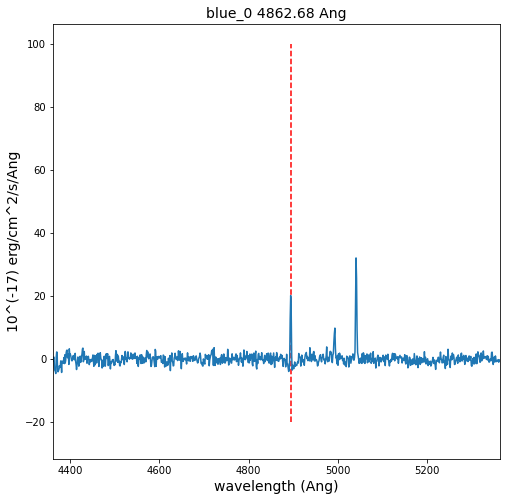

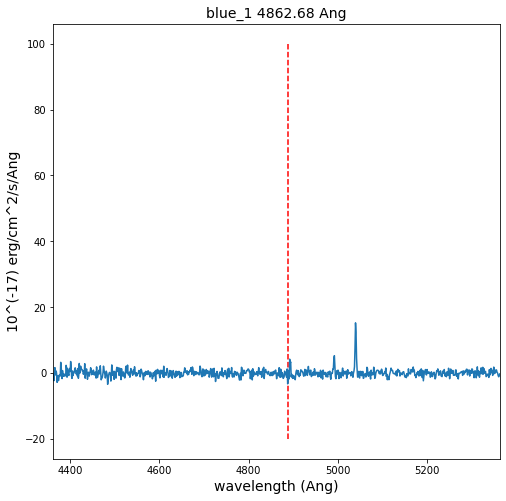

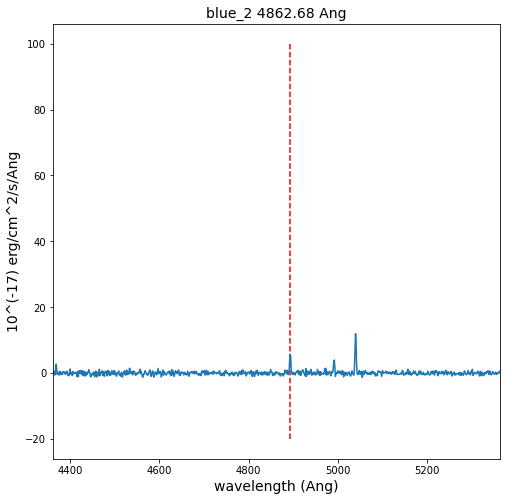

In [14]:
#get spectra from SDSS of the 3 blue objects we've chosen to study
# here we're zooming in on the H-beta line and marking the H-beta line in red 
WAVELENGTH = LINES['Hb']
for i in range(len(blue_plates)):
    mjd = blue_mjds[i]
    plate = blue_plates[i]
    fiber = blue_fibers[i]
    source_filename = sdss_fits_filename(plate, mjd, fiber)
    url = sdss_fits_url(plate, mjd, fiber)
    pic_id = f'blue_{i}'
    source_filepath = f'data/{source_filename}'
    plot_NSA_spectra(url, source_filepath, pic_id, WAVELENGTH, zoom = True)

### 5. Show images of 3 red objects

Below I choose 3 red objects from the blue cloud and show their images in the g band and the r band. 

In [15]:
# Choose a 3 red sequence objects to show images/spectra of

#red:
wh_red = np.where(r<-22)
#choose 0, 1, 2 as reds
red_0 = wh_red[0][0]
red_1 = wh_red[0][1]
red_2 = wh_red[0][2]
#get the coords
red_0_subdir = SUBDIR[red_0]
red_0_pid = PID[red_0]
red_0_iauname = IAUNAME[red_0]
red_0_aid = AID[red_0]
red_0_plate = PLATE[red_0]
red_0_fiber = FIBER[red_0]
red_0_mjd = MJD[red_0]
#get the coords
red_1_subdir = SUBDIR[red_1]
red_1_pid = PID[red_1]
red_1_iauname = IAUNAME[red_1]
red_1_aid = AID[red_1]
red_1_plate = PLATE[red_1]
red_1_fiber = FIBER[red_1]
red_1_mjd = MJD[red_1]
#get the coords
red_2_subdir = SUBDIR[red_2]
red_2_pid = PID[red_2]
red_2_iauname = IAUNAME[red_2]
red_2_aid = AID[red_2]
red_2_plate = PLATE[red_2]
red_2_fiber = FIBER[red_2]
red_2_mjd = MJD[red_2]

#pack into lists
red_subdirs = [red_0_subdir , red_1_subdir, red_2_subdir]
red_pids = [red_0_pid , red_1_pid, red_2_pid]
red_iaunames = [red_0_iauname , red_1_iauname, red_2_iauname]
red_aids = [red_0_aid , red_1_aid, red_2_aid]
red_plates = [red_0_plate , red_1_plate, red_2_plate]
red_mjds = [red_0_mjd , red_1_mjd, red_2_mjd]
red_fibers = [red_0_fiber , red_1_fiber, red_2_fiber]

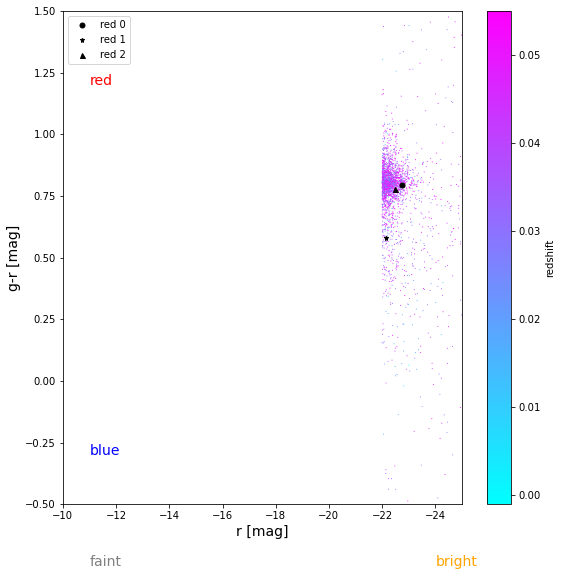

In [16]:
# plot which red objects we're taking a closer look at

fig, ax = plt.subplots(figsize = (8,8))
plt.scatter(r[wh_red], (g - r)[wh_red], s=1, lw=0, c=z[wh_red], cmap=plt.cm.cool, zorder=0)
plt.colorbar(ticks=np.linspace(0, 0.05, 6)).set_label('redshift')
plt.plot(r[red_0], (g - r)[red_0], marker = 'o', color = 'black', linestyle = 'None', markersize = 5, label = 'red 0', zorder=1)
plt.plot(r[red_1], (g - r)[red_1], marker = '*', color = 'black',  linestyle = 'None', markersize = 5, label = 'red 1', zorder=1)
plt.plot(r[red_2], (g - r)[red_2], marker = '^', color = 'black',  linestyle = 'None', markersize = 5, label = 'red 2', zorder=1)

plt.ylim(-0.5, 1.5)
plt.xlim(-10, -25)

plt.text(-11, -.3, 'blue', color = 'blue', fontsize = 14)
plt.text(-11, 1.2, 'red', color = 'red', fontsize = 14)

plt.text(-11, -.75, 'faint', color = 'grey', fontsize = 14)
plt.text(-24,-0.75, 'bright', color = 'orange', fontsize = 14)

plt.ylabel('g-r [mag]', fontsize=14)
plt.xlabel('r [mag]', fontsize=14)
plt.legend()
plt.tight_layout()

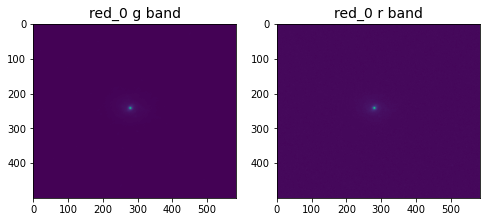

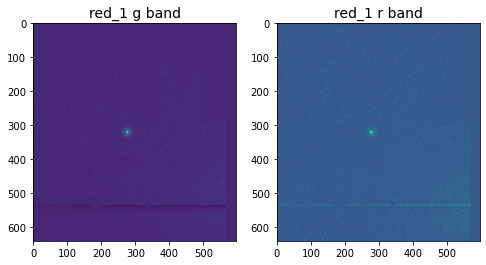

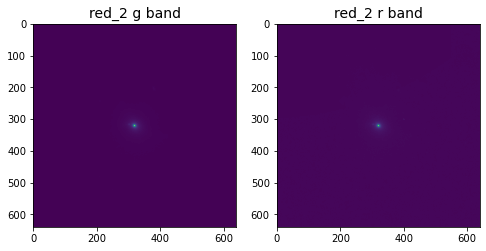

In [17]:
# plot the g and r band images of the 3 red objects we've chosen to study
for i in range(len(red_pids)):
    pid = red_pids[i]
    iauname = red_iaunames[i]
    pid = red_pids[i]
    aid = red_aids[i]
    subdir = red_subdirs[i]
    #for child image
    url = f'http://sdss.physics.nyu.edu/mblanton/v0/detect/v0_1/{subdir}/atlases/{pid}/{iauname}-{pid}-atlas-{aid}.fits.gz'
    source_filepath = f'data/{iauname}-{pid}-atlas-{aid}.fits.gz'
    pic_id = f'red_{i}'
    #for parent image
    #url = f'http://sdss.physics.nyu.edu/mblanton/v0/detect/v0_1/{subdir}/atlases/{pid}/{iauname}-parent-{pid}.fits.gz'
    #source_filepath = 'data/{iauname}-parent-{pid}.fits.gz'
    plot_NSA_images(url, source_filepath, pic_id)

### 6. Show spectra of 3 red objects

In the below, for my 3 chosen red objects, I show 1) their entire SDSS spectrum with the H-alpha line marked in red, 2) their SDSS spectrum zoomed in on the H-alpha line with the H-alpha line marked in red, and 3) their SDSS spectrum zoomed in on the H-beta line (~4000 Ang in vacuum) with the H-beta line marked in red.

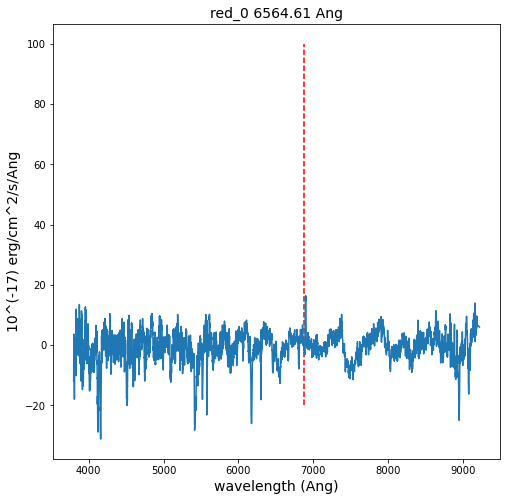

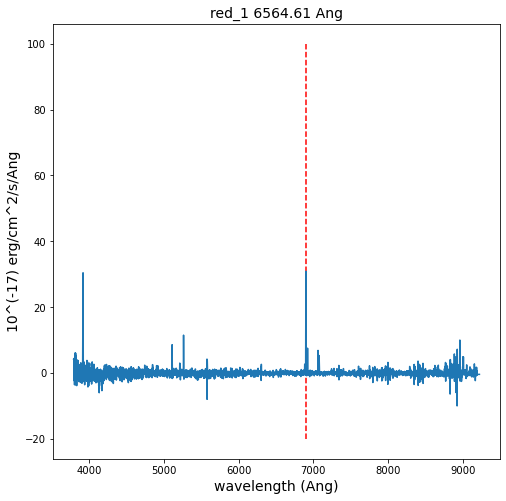

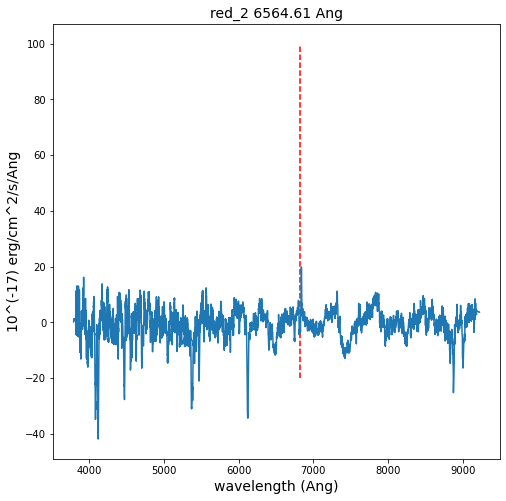

In [18]:
#get spectra from SDSS of the 3 red objects we've chosen to study
# here we're plotting the full spectrum and marking the H-alpha line in red 
WAVELENGTH = LINES['Ha']
for i in range(len(red_plates)):
    mjd = red_mjds[i]
    plate = red_plates[i]
    fiber = red_fibers[i]
    source_filename = sdss_fits_filename(plate, mjd, fiber)
    url = sdss_fits_url(plate, mjd, fiber)
    pic_id = f'red_{i}'
    source_filepath = f'data/{source_filename}'
    plot_NSA_spectra(url, source_filepath, pic_id, WAVELENGTH, zoom = False)

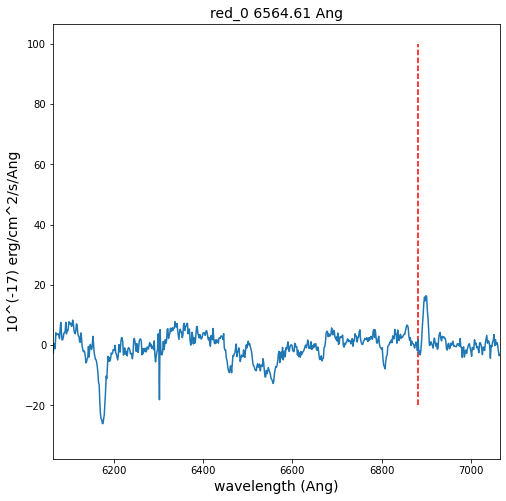

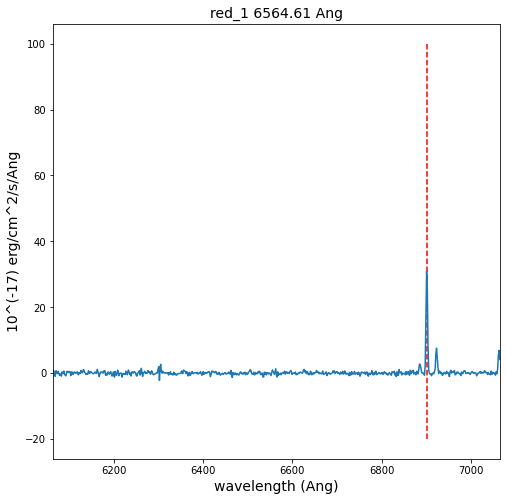

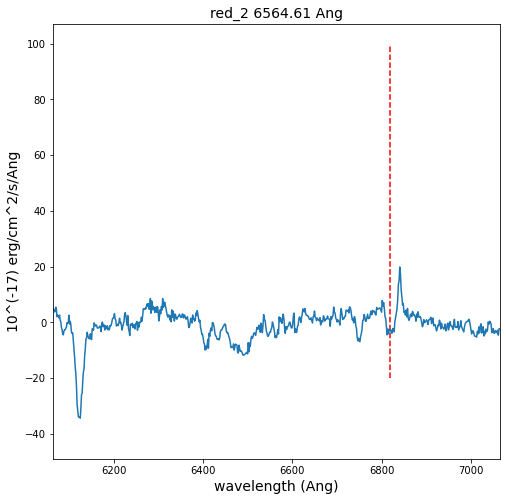

In [19]:
#get spectra from SDSS of the 3 red objects we've chosen to study
# here we're zooming in on the H-alpha line and marking the H-alpha line in red 
WAVELENGTH = LINES['Ha']
for i in range(len(red_plates)):
    mjd = red_mjds[i]
    plate = red_plates[i]
    fiber = red_fibers[i]
    source_filename = sdss_fits_filename(plate, mjd, fiber)
    url = sdss_fits_url(plate, mjd, fiber)
    pic_id = f'red_{i}'
    source_filepath = f'data/{source_filename}'
    plot_NSA_spectra(url, source_filepath, pic_id, WAVELENGTH, zoom = True)

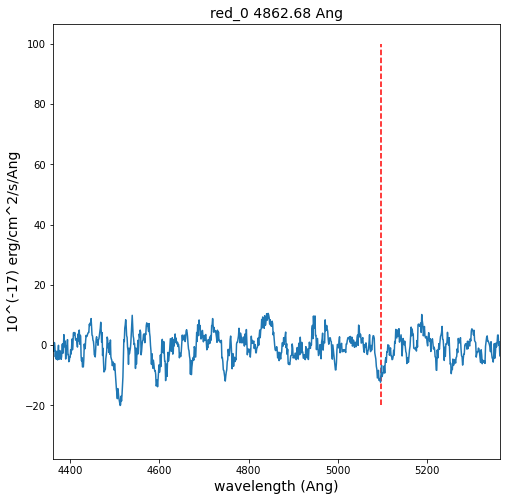

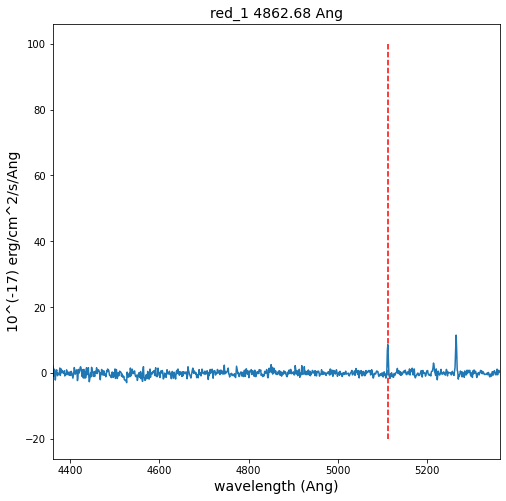

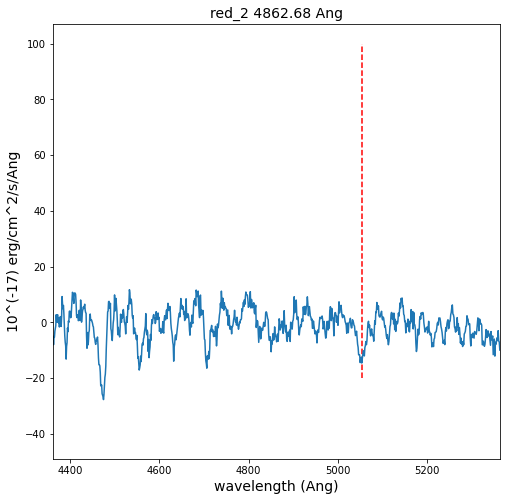

In [20]:
#get spectra from SDSS of the 3 red objects we've chosen to study
# here we're zooming in on the H-beta line and marking the H-beta line in red 
WAVELENGTH = LINES['Hb']
for i in range(len(red_plates)):
    mjd = red_mjds[i]
    plate = red_plates[i]
    fiber = red_fibers[i]
    source_filename = sdss_fits_filename(plate, mjd, fiber)
    url = sdss_fits_url(plate, mjd, fiber)
    pic_id = f'red_{i}'
    source_filepath = f'data/{source_filename}'
    plot_NSA_spectra(url, source_filepath, pic_id, WAVELENGTH, zoom = True)

### 7. Comparison between blue and red galaxies

#### a) Comparison of images: 
The blue galaxies look more asymmetric, like they may have features like arms or bulges and are therefore non-spherical. However, the red galaxies look pretty spherical. This is because blue galaxies tend to be young, late-type spiral galaxies, while the red galaxies tend to be old, early-type elliptical galaxies. 

#### b) Comparison of spectra: 
The blue galaxies' spectra are blueshifted, meaning that frequencies are shifted downward (compared to the redshifted galaxies). So the blue galaxies' spectrum peaks should be pretty close to the red lines that mark the H-alpha and H-beta peaks. When I look at the blue galaxies' spectra I see that this is generally true: the red lines mark the peaks of the blue galaxy spectra.

Similarly, the red galaxies' spectra are redshifted, meaning that frequencies are shifted upward. So the red galaxies' spectrum peaks should be to the right of the red lines that mark the H-alpha and H-beta peaks. When I look at the red galaxies' spectra I see that this also is generally true.

Additionally, it looks like the blue spectra have high, skinny peaks while the red spectra have lower peaks but more power dispersed throughout the entire wavelength range of the spectra. Maybe this is because blue galaxies tend to be very organized (spirals) where stars tend to travel in roughly the same plane, while red galaxies are "random" (ellipticals) where stars have randomly oriented orbits. The ordered blue galaxies produce "clean" power spectra, while the "random" red galaxies produce "noisier" power spectra. 